In [1]:
import os
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
home_dir = os.path.join(os.getenv("HOME"), "geodata", "geo411", "GEO411_FSH_Roda")
# change to home_dir
os.chdir(home_dir)

# define paths

In [3]:
# define path for dem and sar image
lidar = "ancillary_data/LAS_diff_Roda_10m_median_NA.tif"
bs_hv =  "snap_grd/20150821/ALOS2-FBDR1_1__A-ORBIT__ALOS2067251007-150821_Cal_TF_TC.tif"

# Reproject data

In [8]:
reprojected_lidar = "ancillary_data/roda_10m_32632.tif"
reprojected_backscatter = "snap_grd/20150821/ALOS2_20150821_linear_32632.tif"

if not os.path.exists(reprojected_dem):
    # reproject dem
    cmd = "gdalwarp -t_srs EPSG:32632 {dem_4326} {lidar_repro}".format(dem_4326=dem, lidar_repro=reprojected_lidar)
    os.system(cmd)
else: print("10m Lidar DEM already exists in 32632")

if not os.path.exists(reprojected_backscatter):
    # reproject backscatter
    cmd = "gdalwarp -t_srs EPSG:32632 {bs_4326} {bs_repro}".format(bs_4326=bs_hv, bs_repro=reprojected_backscatter)
    os.system(cmd)
else: print("The reprojected Backscatter already exists")

10m Lidar DEM already exists in 32632
The reprojected Backscatter already exists


# Mask Lidar Canopy Height by FNF

In [7]:
fnf = "ancillary_data/FNF/cropped_mask__20m_4326.tif"
fnf_repro = "ancillary_data/FNF/cropped_mask_20m_32632.tif"
if not os.path.exists(fnf_repro):
    cmd = "gdalwarp -t_srs EPSG:32632 -tr 20 20 {fnf} {fnf_repro}".format(fnf=fnf, fnf_repro=fnf_repro)
    os.system(cmd)
else: print("already exists")

In [13]:
tile_lidar = "ancillary_data/las_extent.shp"
tile_fnf = "ancillary_data/FNF/fnf_tile.shp"

if not os.path.exists(tile_fnf):
    cmd = "gdaltindex {tile_fnf} {fnf_tif}".format(tile_fnf=tile_fnf, fnf_tif=fnf_repro)
    os.system(cmd)
else: print("Tile for FNF already exists")

if not os.path.exists(tile_lidar):
    cmd = "gdaltindex {lidar_tile} {lidar_tif}".format(lidar_tile=tile_lidar, lidar_tif=reprojected_lidar)
    os.system(cmd)
else: print("Lidar Tile already exists")

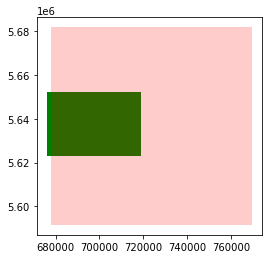

In [17]:
import geopandas as gpd
from shapely.geometry import Polygon
# read lidar extent
lidar_extent = gpd.read_file(tile_lidar)
# read fnf extent
fnf_extent = gpd.read_file(tile_fnf)
# plot them
ax = lidar_extent.plot(color="green")
fnf_extent.plot(ax=ax, color="red", alpha=.2)

In [18]:
# compute intersection
intersection_lidar_fnf = "ancillary_data/fnf_lidar_intersection.shp"

# compute intersection
intersection = gpd.overlay(lidar_extent, fnf_extent, how="intersection")

# write file
if not os.path.exists(intersection_lidar_fnf):
    intersection.to_file(intersection_lidar_fnf)
else: print("intersection shape already exists")

In [28]:
# crop both to their common extent

cropped_lidar = "ancillary_data/lidar_20m_cropped_to_fnf.tif"
cropped_fnf = "ancillary_data/FNF/cropped_to_lidar_fnf_20m_32632.tif"

if not os.path.exists(cropped_lidar):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 20 20 {lidar} {cropped_lidar}".format(intersection=intersection_lidar_fnf,
                                                                                                   lidar=reprojected_lidar,
                                                                                                   cropped_lidar=cropped_lidar)
    os.system(cmd)
else: print("cropped, reprojected and resampled Lidar CHM already exists")
    
if not os.path.exists(cropped_fnf):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 20 20 {fnf} {cropped_fnf}".format(intersection=intersection_lidar_fnf,
                                                                                                   fnf=fnf_repro,
                                                                                                   cropped_fnf=cropped_fnf)
    os.system(cmd)
else: print("cropped fnf already exists")

cropped fnf already exists


In [29]:
# read both and check for common extent
lidar = gdal.Open(cropped_lidar, gdal.GA_ReadOnly)
fnf = gdal.Open(cropped_fnf, gdal.GA_ReadOnly)
# get both band
lidar_array = lidar.GetRasterBand(1).ReadAsArray()
fnf_array = fnf.GetRasterBand(1).ReadAsArray()
# 1 is forest, 0 is non-forest
lidar_array.shape == fnf_array.shape

True

- Now do the work in Qgis
    + `(fnf / fnf) * lidar`

# Compute Tileindexes


In [30]:
tile_sar = "ancillary_data/sar_extent.shp"
tile_dem = "ancillary_data/las_10m_extent.shp"

if not os.path.exists(tile_sar):
    cmd = "gdaltindex {sar_extent_shape} {sar_backscatter_tif}".format(sar_extent_shape=tile_sar, 
                                                                sar_backscatter_tif=reprojected_backscatter)
    os.system(cmd)
else: print("Tile for reprojected backscatter SAR Scene already exists")

if not os.path.exists(tile_dem):
    cmd = "gdaltindex {dem_extent_shape} {dem}".format(dem_extent_shape=tile_dem, 
                                                    dem=reprojected_dem)
    os.system(cmd)
else: print("Tile for reprojected DEM already exists")

Tile for reprojected backscatter SAR Scene already exists
Tile for reprojected DEM already exists


# Calculate intersection between Lidar and Backscatter

In [31]:
#!ogr2ogr intersection.shp ancillary_data/tiles.vrt -dialect sqlite -sql "SELECT ST_Intersection(las_10m_extent.geometry, sar_extent.geometry) AS geometry FROM las_10m_extent, sar_extent"
import geopandas as gpd
from shapely.geometry import Polygon

# read lidar extent
lidar_extent = gpd.read_file(tile_dem)

# read sar extent
sar_extent = gpd.read_file(tile_sar)

## Plot the two shapefiles

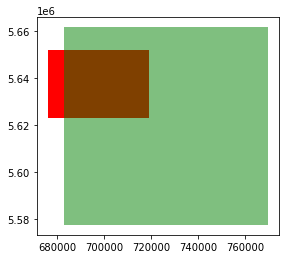

In [34]:
ax = lidar_extent.plot(color="red")
sar_extent.plot(ax=ax, color="green", alpha=0.5)

intersection shape already exists


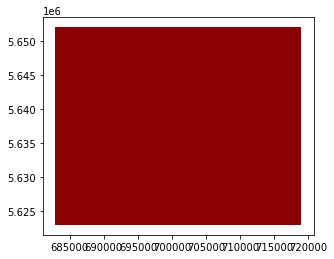

In [35]:
intersection_shape = "ancillary_data/intersection.shp"

# plot only intersection
intersection = gpd.overlay(lidar_extent, sar_extent, how="intersection")
ax = intersection.plot(color="darkred")

# write file
if not os.path.exists(intersection_shape):
    intersection.to_file("ancillary_data/intersection.shp")
else: print("intersection shape already exists")

# Crop both rasters to intersection

In [37]:
# lidar chm uncropped
lidar = "ancillary_data/chm_maskedtofnf_10m_resampled_to_20m_32632.tif"
# target data
chm_20m_32632_final = "ancillary_data/chm_maskedtofnf_10m_resampled_to_20m_32632_cropped_to_intersection.tif"
bs_20m_32632_final = "snap_grd/20150821/ALOS2_20150821_LINEAR_hv_32632_20_20_cropped.tif"

if not os.path.exists(chm_20m_32632_final):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 20 20 {lidar} {lidar_cropped}".format(intersection=intersection_shape,
                                                                                                   lidar=lidar,
                                                                                                   lidar_cropped=chm_20m_32632_final)
    os.system(cmd)
else: print("cropped, reprojected and resampled DEM already exists")
    
if not os.path.exists(bs_20m_32632_final):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 20 20 {bs} {bs_cropped}".format(intersection=intersection_shape,
                                                                                                   bs=reprojected_backscatter,
                                                                                                   bs_cropped=bs_20m_32632_final)
    os.system(cmd)
else: print("cropped, reprojected and resampled sar-backsactter already exists")

cropped, reprojected and resampled sar-backsactter already exists


# Plot Lidar Canopy Height vs Backscatter

In [38]:
import numpy as np
import rasterio
from rasterio import features
from rasterio.mask import mask
import fiona

[ NO DATA VALUE Backscatter ] =  None
[ NO DATA VALUE LIDAR ] =  None


Text(0.5, 1.0, 'Lidar CHM')

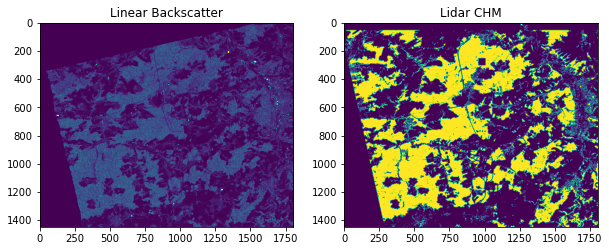

In [66]:
# read both rasters with gdal
ds_bs = gdal.Open(bs_20m_32632_final, gdal.GA_ReadOnly)
ds_lidar = gdal.Open(chm_20m_32632_final, gdal.GA_ReadOnly)

# get the first band 
bs = ds_bs.GetRasterBand(1)
lidar = ds_lidar.GetRasterBand(1)

# Snap can't handle nodatavals in export of geotiff really well...
print("[ NO DATA VALUE Backscatter ] = ", bs.GetNoDataValue())
print("[ NO DATA VALUE LIDAR ] = ", bs.GetNoDataValue())

# read them into an array
bs_array = bs.ReadAsArray()
lidar_array = lidar.ReadAsArray()


fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(bs_array, vmin=0, vmax=0.3)
ax.set_title("Linear Backscatter")

ax = fig.add_subplot(1,2,2)
ax.imshow(lidar_array)
ax.set_title("Lidar CHM")

In [67]:
# check if they have the same extent
bs_array.shape == dem_array.shape

True

- as Snap doesn't export any NoData, the parts where the backscatter is 0 is assumed to be Nodata


<ipython-input-73-7b9ef75d1ea1>:1: RuntimeWarning: invalid value encountered in less_equal
  bs_array[bs_array <= 0] = np.nan
<ipython-input-73-7b9ef75d1ea1>:2: RuntimeWarning: invalid value encountered in less_equal
  lidar_array[lidar_array <= 0] = np.nan


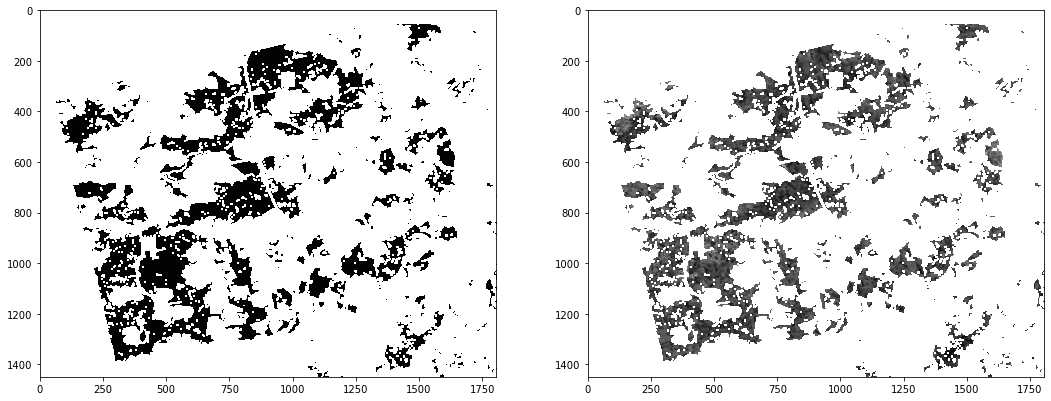

In [73]:
bs_array[bs_array <= 0] = np.nan
lidar_array[lidar_array <= 0] = np.nan
bs_array[np.where(np.isnan(lidar_array))] = np.nan
lidar_array[np.where(np.isnan(bs_array))] = np.nan

fig,(axs1, axs2) = plt.subplots(1,2, figsize=(18,16))
bs = axs1.imshow(bs_array, cmap="gray")
dem = axs2.imshow(lidar_array, cmap="gray")

Text(0, 0.5, 'Linear Radar Backscatter')

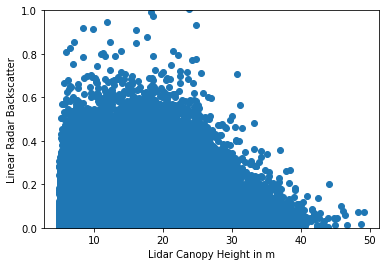

In [74]:
plt.scatter(lidar_array, bs_array)
plt.ylim(0,1)
plt.xlabel("Lidar Canopy Height in m")
plt.ylabel("Linear Radar Backscatter")

In [78]:
lidar_array = lidar_array[np.logical_not(np.isnan(lidar_array))]
bs_array = bs_array[np.logical_not(np.isnan(bs_array))]

from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([lidar_array,bs_array])
z = gaussian_kde(xy)(xy)

KeyboardInterrupt: 